<a href="https://colab.research.google.com/github/mahault/gridworld/blob/main/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
!pip install inferactively-pymdp

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import os
from matplotlib.colors import LinearSegmentedColormap

def red_white_green_cmap():
    # red -> white -> green
    return LinearSegmentedColormap.from_list("rwg", ["#d73027", "#ffffff", "#1a9850"], N=256)


# -------------------------------------------------------
# Helper: convert linear index -> (row, col)
# -------------------------------------------------------
def idx_to_xy(k, grid_n=3):
    """Convert linear index to (row, col)."""
    return divmod(k, grid_n)


# -------------------------------------------------------
# Render a single frame of the gridworld
# -------------------------------------------------------
def render_grid_frame(agent_idx, food_idx, grid_n=3, show_text=True):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    from PIL import Image

    # Bigger canvas + no padding around axes
    fig, ax = plt.subplots(figsize=(grid_n/2, grid_n/2), dpi=100)
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # --- key: give a half-cell margin so edge lines are inside the frame ---
    ax.set_xlim(-0.5, grid_n + 0.5)
    ax.set_ylim(-0.5, grid_n + 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    # draw outer border (helps visibility on some backends)
    ax.add_patch(Rectangle((0, 0), grid_n, grid_n, fill=False, linewidth=1.5))

    # draw grid lines at integer coordinates 0..grid_n
    for g in range(grid_n + 1):
        ax.plot([g, g], [0, grid_n], lw=0.6, color='gray')
        ax.plot([0, grid_n], [g, g], lw=0.6, color='gray')

    # food
    fy, fx = divmod(food_idx, grid_n)
    ax.add_patch(Rectangle((fx, fy), 1, 1, fill=False, linewidth=2))
    if show_text:
        ax.text(fx + 0.5, fy + 0.6, "F", ha="center", va="center",
                fontsize=16, fontweight="bold", color="red")

    # agent
    ay, axx = divmod(agent_idx, grid_n)
    if show_text:
        ax.text(axx + 0.5, ay + 0.5, "A", ha="center", va="center",
                fontsize=16, fontweight="bold", color="blue")

    ax.axis("off")

    # backend-safe to PIL
    fig.canvas.draw()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    img = Image.frombytes("RGBA", (w, h), buf)
    plt.close(fig)
    return img.convert("RGB")


def render_belief_heatmap(q_food, grid_n=3):
    """
    Render a single heatmap frame (PIL.Image) for the posterior over food location.
    Uses a diverging scale centered at the uniform prior.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    # reshape vector to grid
    mat = q_food.reshape((grid_n, grid_n))

    # center on uniform prior so white = 'no information'
    u = 1.0 / (grid_n * grid_n)
    delta = mat - u
    vmax = max(abs(delta.min()), abs(delta.max()))
    vmin = -vmax

    fig, ax = plt.subplots(figsize=(grid_n/2, grid_n/2), dpi=100)
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

    im = ax.imshow(delta, cmap=red_white_green_cmap(), vmin=vmin, vmax=vmax, origin="upper")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title("Belief: food location (Δ vs. uniform)", fontsize=10, pad=4)

    # to PIL (backend-safe)
    fig.canvas.draw()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    img = Image.frombytes("RGBA", (w, h), buf)
    plt.close(fig)
    return img.convert("RGB")


# -------------------------------------------------------
# Save a GIF from a trajectory of agent positions
# -------------------------------------------------------

def save_beliefs_gif(beliefs_list, out_path, grid_n=3, fps=2):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    frames = [render_belief_heatmap(b, grid_n=grid_n) for b in beliefs_list]
    duration_ms = int(1000 / max(1, fps))
    frames[0].save(out_path, save_all=True, append_images=frames[1:], duration=duration_ms, loop=0)
    return out_path

def save_gridworld_gif(agent_path, food_idx, out_path, grid_n=3, fps=2):
    """
    Saves a GIF visualizing agent movement in the grid.

    Args:
        agent_path (list[int]): Sequence of agent positions (indices).
        food_idx (int): Fixed food location.
        out_path (str): Path to save the GIF.
        grid_n (int): Grid dimension.
        fps (int): Frames per second (animation speed).
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    frames = [render_grid_frame(a, food_idx, grid_n=grid_n) for a in agent_path]
    duration_ms = int(1000 / max(1, fps))
    frames[0].save(out_path, save_all=True, append_images=frames[1:], duration=duration_ms, loop=0)
    return out_path

In [119]:
# pip install inferactively-pymdp

import numpy as np
from pymdp import utils
from pymdp.agent import Agent
from pymdp import control

# ---------- 1) Helpers for 3x3 grid ----------
GRID_N = 10     # or 20, or however large you want
N_CELLS = GRID_N * GRID_N

# Food-sighting modality outcomes (relative to agent)
FOOD_NONE  = 0   # no food visible in {here, up, down, left, right}
FOOD_HERE  = 1
FOOD_UP    = 2
FOOD_DOWN  = 3
FOOD_LEFT  = 4
FOOD_RIGHT = 5

N_FOOD_OBS = 6   # size of the new modality

def idx_to_xy(k):
    return divmod(k, GRID_N)  # (row=y, col=x)

def xy_to_idx(y, x):
    return y * GRID_N + x

ACTION_NAMES = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]
UP, DOWN, LEFT, RIGHT, STAY = range(5)

def step_cell(prev_idx, action):
    y, x = idx_to_xy(prev_idx)
    if action == UP:
        y = max(0, y - 1)
    elif action == DOWN:
        y = min(GRID_N - 1, y + 1)
    elif action == LEFT:
        x = max(0, x - 1)
    elif action == RIGHT:
        x = min(GRID_N - 1, x + 1)
    elif action == STAY:
        pass
    return xy_to_idx(y, x)

def manhattan(i, j):
    yi, xi = idx_to_xy(i)
    yj, xj = idx_to_xy(j)
    return abs(yi - yj) + abs(xi - xj)

def food_obs_relative(agent_idx, food_idx, grid_n=GRID_N):
    ay, ax = idx_to_xy(agent_idx)
    fy, fx = idx_to_xy(food_idx)
    dy, dx = fy - ay, fx - ax
    if dy == 0 and dx == 0:
        return FOOD_HERE
    if dy == -1 and dx == 0 and ay > 0:
        return FOOD_UP
    if dy == 1 and dx == 0 and ay < grid_n - 1:
        return FOOD_DOWN
    if dy == 0 and dx == -1 and ax > 0:
        return FOOD_LEFT
    if dy == 0 and dx == 1 and ax < grid_n - 1:
        return FOOD_RIGHT
    return FOOD_NONE



In [120]:
# ---------- 2) Build A (likelihoods) ----------
# Two modalities: [0]=self-location (9 outcomes), [1]=food-sighting (6 outcomes)
num_obs = [N_CELLS, N_FOOD_OBS]
num_states = [N_CELLS, N_CELLS]   # factors: [agent_loc, food_loc]

A = utils.obj_array(len(num_obs))

# Modality 0: perfect self-location cue, independent of food
A_loc = np.zeros((N_CELLS, N_CELLS, N_CELLS))
for s_agent in range(N_CELLS):
    for s_food in range(N_CELLS):
        A_loc[s_agent, s_agent, s_food] = 1.0
A[0] = A_loc

# Modality 1: relative food-sighting (HERE / UP / DOWN / LEFT / RIGHT / NONE)
A_food = np.zeros((N_FOOD_OBS, N_CELLS, N_CELLS))
for s_agent in range(N_CELLS):
    for s_food in range(N_CELLS):
        outcome = food_obs_relative(s_agent, s_food, GRID_N)
        A_food[outcome, s_agent, s_food] = 1.0
A[1] = A_food





In [121]:
# ---------- 3) Build B (transitions) ----------
B = utils.obj_array(len(num_states))

# Factor 0 (agent location): 5 actions (UP, DOWN, LEFT, RIGHT, STAY)
n_actions_agent = 5  # UP, DOWN, LEFT, RIGHT, STAY
B_agent = np.zeros((N_CELLS, N_CELLS, n_actions_agent))
for a in range(n_actions_agent):
    for s_prev in range(N_CELLS):
        s_next = step_cell(s_prev, a)
        B_agent[s_next, s_prev, a] = 1.0
B[0] = B_agent

# Factor 1 (food location): uncontrolled, static (1 "action")
B_food = np.zeros((N_CELLS, N_CELLS, 1))
np.fill_diagonal(B_food[:, :, 0], 1.0)
B[1] = B_food

num_controls = [n_actions_agent, 1]  # agent controllable, food not

In [122]:
# ---------- 4) Preferences C (log-preferences over each modality’s outcomes) ----------
# Neutral about self-location; prefer proximity HERE > ADJACENT > NONE
C = utils.obj_array_zeros(num_obs)
C[0] = np.zeros(N_CELLS)  # indifferent to self-location

# Log-preferences over food-sighting outcomes
C_food = np.array([
    -2.0,  # FOOD_NONE
     3.0,  # FOOD_HERE (reward)
     0.0,  # FOOD_UP
     0.0,  # FOOD_DOWN
     0.0,  # FOOD_LEFT
     0.0   # FOOD_RIGHT
])
C[1] = C_food


In [123]:
# ---------- 5) Priors D over initial hidden states ----------
D = utils.obj_array(len(num_states))
start_agent = xy_to_idx(GRID_N // 2, GRID_N // 2)   # start in the middle
D[0] = utils.onehot(start_agent, N_CELLS)
D[1] = np.ones(N_CELLS) / N_CELLS



In [124]:
# ---------- 6) Enumerate policies (planning horizon) ----------
policy_len = 3  # try 3-step plans; increase to 4 if you want deeper foresight
policies = control.construct_policies(
    num_states=num_states,
    num_controls=num_controls,
    policy_len=policy_len,
    control_fac_idx=[0]  # only the agent-location factor is controllable
)



In [125]:
# ---------- 7) Build the Agent ----------
agent = Agent(
    A=A, B=B, C=C, D=D,
    policies=policies,
    policy_len=policy_len,
    num_controls=num_controls,
    control_fac_idx=[0],
    inference_algo='VANILLA',         # single-step state inference
    use_states_info_gain=True,        # epistemic term on
    use_param_info_gain=False,        # no learning in this demo
    action_selection='deterministic', # pick MAP action
    gamma=16.0, alpha=16.0
)



In [126]:
# ---------- 8) Simple environment (generative process) ----------
class GridFoodEnv:
    def __init__(self, start_agent_idx, food_idx=None):
        self.agent = start_agent_idx
        self.food = np.random.randint(N_CELLS) if food_idx is None else food_idx

    def observe(self):
        # Modality 0: self-location index (as before)
        o_loc = self.agent
        # Modality 1: relative food sighting (new)
        o_food = food_obs_relative(self.agent, self.food, GRID_N)
        return [o_loc, o_food]

    def step(self, action_index):
        self.agent = step_cell(self.agent, action_index)
        return self.observe()




In [127]:
# ---------- 9) Run a single episode ----------
env = GridFoodEnv(start_agent_idx=start_agent, food_idx=None)   # randomize food
obs = env.observe()
agent_positions = [env.agent]      # start position
food_index = env.food              # fixed for the episode


T = 50
history = {"obs": [], "act": [], "food_mode": [], "food_entropy": []}
beliefs_food = []         # list of length T', each is shape (N_CELLS,)
beliefs_food.append((np.ones(N_CELLS) / N_CELLS))  # t=0 prior (before 1st action)

for t in range(T):
    # infer latent states given current observation
    qs = agent.infer_states(obs)      # qs[0]: agent-loc belief; qs[1]: food-loc belief

    # policy inference / action selection
    q_pi, neg_efe = agent.infer_policies()
    action_vec = agent.sample_action()
    action = int(action_vec[0])       # first (and only) controllable factor

    # logging food belief diagnostics

    q_food = qs[1]
    beliefs_food.append(q_food.copy())
    food_mode = int(np.argmax(q_food))
    food_entropy = -np.sum(q_food * np.log(q_food + 1e-16))

    history["obs"].append(tuple(obs))
    history["act"].append(ACTION_NAMES[action])
    history["food_mode"].append(food_mode)
    history["food_entropy"].append(food_entropy)

    # step the environment
    obs = env.step(action)
    agent_positions.append(env.agent)

    # stop if found
    if obs[1] == FOOD_HERE:
        print(f"Found at step {t+1}.")
        break

print("True food at:", env.food)
print("Agent belief mode:", history["food_mode"][-1], "entropy:", round(history["food_entropy"][-1], 3))
print("Steps:", len(history["act"]), "Actions:", history["act"])

Found at step 21.
True food at: 52
Agent belief mode: 52 entropy: 0.0
Steps: 21 Actions: ['UP', 'UP', 'UP', 'UP', 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN', 'DOWN', 'DOWN', 'DOWN', 'DOWN', 'DOWN', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'LEFT', 'UP', 'UP']


Saved: /content/sample_data/agent_food_3x3.gif


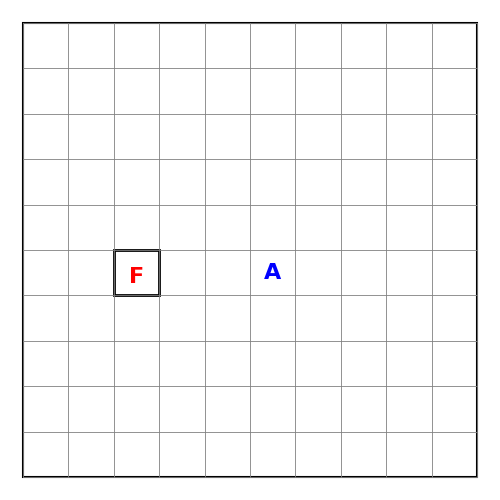

Saved beliefs GIF: /content/sample_data/beliefs_food_10x10.gif


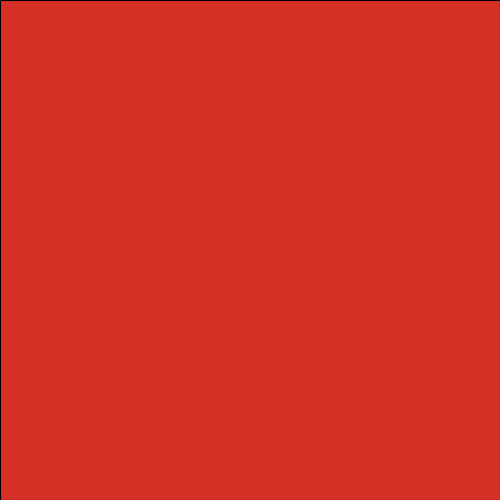

In [128]:


# Choose a Colab-safe output folder
out_dir = "/content/sample_data"
os.makedirs(out_dir, exist_ok=True)

gif_path = os.path.join(out_dir, "agent_food_3x3.gif")

# Make sure you have at least one position in agent_positions
assert len(agent_positions) > 0, "agent_positions is empty"

save_gridworld_gif(agent_positions, food_index, gif_path, grid_n=GRID_N, fps=2)
print("Saved:", gif_path)

# (Optional) Show it inline in Colab
from IPython.display import Image, display
display(Image(filename=gif_path))

beliefs_gif_path = os.path.join(out_dir, f"beliefs_food_{GRID_N}x{GRID_N}.gif")
save_beliefs_gif(beliefs_food, beliefs_gif_path, grid_n=GRID_N, fps=2)
print("Saved beliefs GIF:", beliefs_gif_path)

from IPython.display import Image, display
display(Image(filename=beliefs_gif_path))


Saved combined GIF: /content/sample_data/path_plus_beliefs_10x10.gif


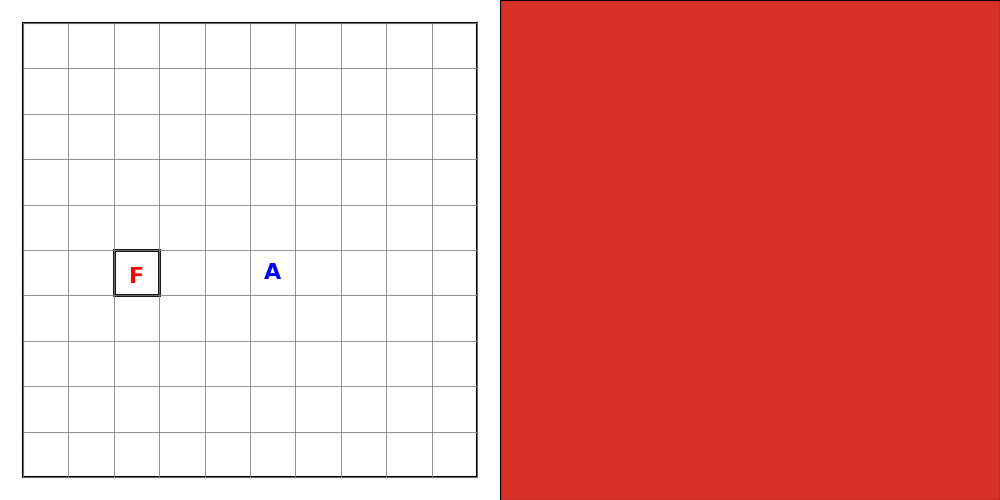

In [131]:
# Pillow (for creating and composing images)
from PIL import Image as PILImage

# IPython (for displaying images inline)
from IPython.display import Image as IPyImage, display

def render_combined_frame(agent_idx, food_idx, q_food, grid_n=3, show_text=True):
    left  = render_grid_frame(agent_idx, food_idx, grid_n=grid_n, show_text=show_text)
    right = render_belief_heatmap(q_food, grid_n=grid_n)
    h = max(left.height, right.height)
    w = left.width + right.width
    combo = PILImage.new("RGB", (w, h), (255, 255, 255))  # <-- use PILImage
    combo.paste(left, (0, 0))
    combo.paste(right, (left.width, 0))
    return combo

def save_combined_gif(agent_positions, food_idx, beliefs_list, out_path, grid_n=3, fps=2, show_text=True):
    frames = [render_combined_frame(a, food_idx, b, grid_n=grid_n, show_text=show_text)
              for a, b in zip(agent_positions, beliefs_list)]
    duration_ms = int(1000 / max(1, fps))
    frames[0].save(out_path, save_all=True, append_images=frames[1:], duration=duration_ms, loop=0)
    return out_path

combined_gif_path = os.path.join(out_dir, f"path_plus_beliefs_{GRID_N}x{GRID_N}.gif")
save_combined_gif(agent_positions, food_index, beliefs_food, combined_gif_path, grid_n=GRID_N, fps=2, show_text=True)
print("Saved combined GIF:", combined_gif_path)
display(IPyImage(filename=combined_gif_path))